In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

In [3]:
lower_percent = np.percentile(data, 1, axis=0)
higher_percent = np.percentile(data, 99, axis=0)

result = np.array([True for i in range(data.shape[0])])
for i in range(len(raw_data.feature_names)):
    lower = data[:,i] >= lower_percent[i]
    higher = data[:,i] <= higher_percent[i]
    result = np.logical_and(result, np.logical_and(lower, higher))
    
data = data[result]

In [4]:
data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [5]:
data.shape

(18310, 8)

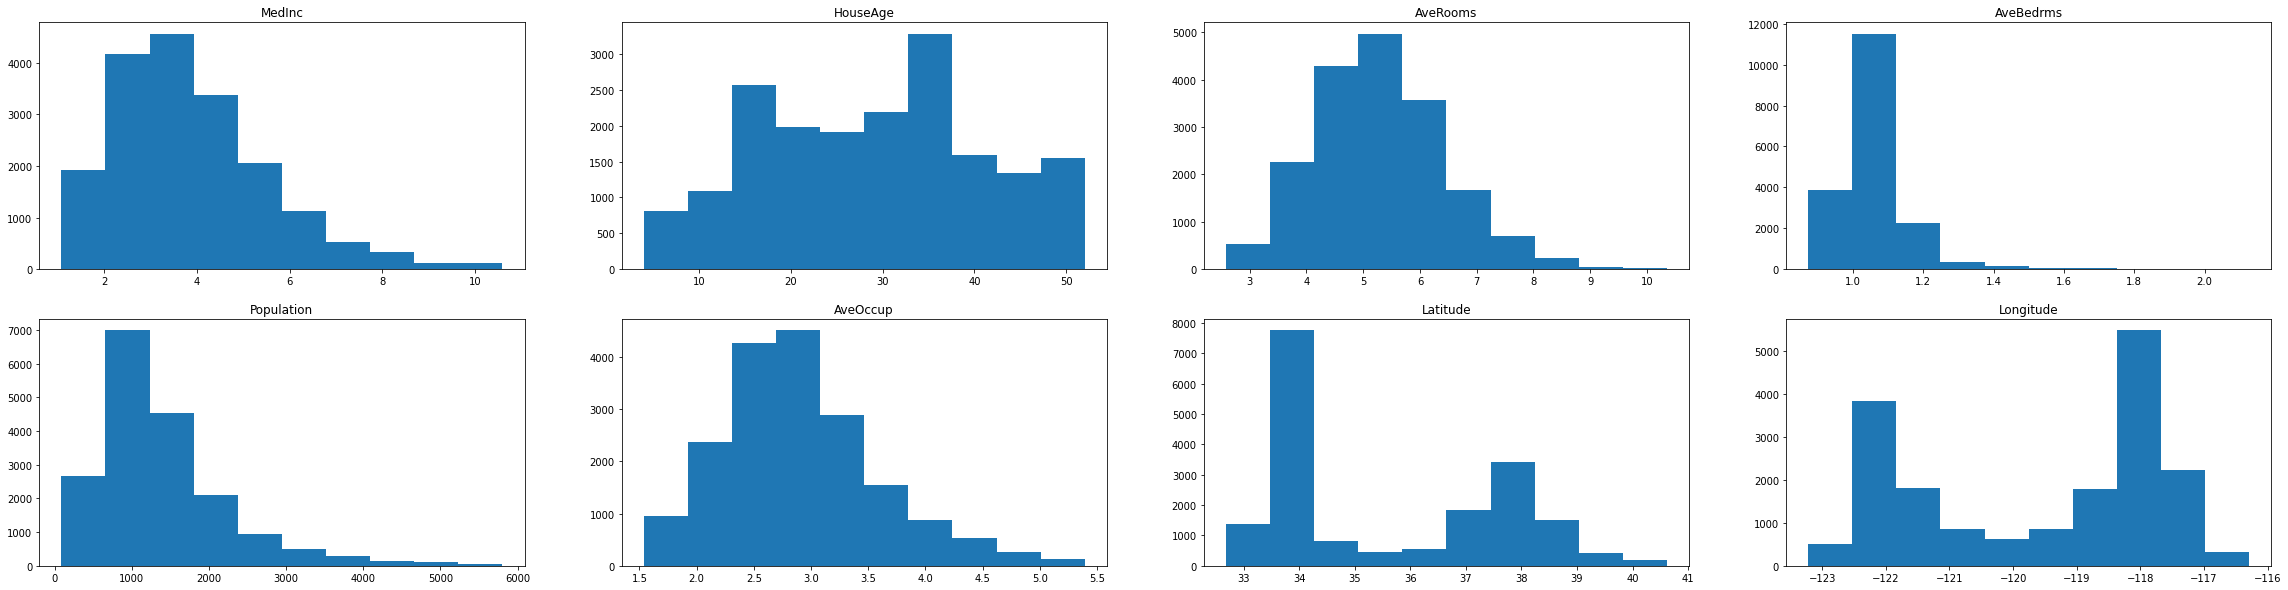

In [6]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))

for i in range(2):
    for j in range(4): 
        axs[i, j].hist(data[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
plt.show()

In [7]:
# Preprocessing 
print(data.shape)
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

(18310, 8)
(12817, 8)
(5493, 8)


In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [9]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 15
LATENT_DIM = 10
BATCH_SIZE = 128
N_EPOCHS = 1000
lr = 1e-3

In [10]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [11]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [12]:
avg_mu_x

array([[ 0.11952385, -0.22042479,  0.06328973, ..., -0.14480321,
         0.09790516, -0.26497552],
       [ 0.11755756, -0.22416067,  0.06735454, ..., -0.14108983,
         0.08907212, -0.27104175],
       [ 0.11649788, -0.22125939,  0.06094529, ..., -0.14494672,
         0.09759095, -0.2702231 ],
       ...,
       [ 0.11915144, -0.22367117,  0.06728471, ..., -0.14182524,
         0.09191292, -0.26946282],
       [ 0.11928859, -0.22024055,  0.06533996, ..., -0.14602393,
         0.09390862, -0.26413703],
       [ 0.11905746, -0.22168745,  0.05904759, ..., -0.14647958,
         0.09064776, -0.2682462 ]], dtype=float32)

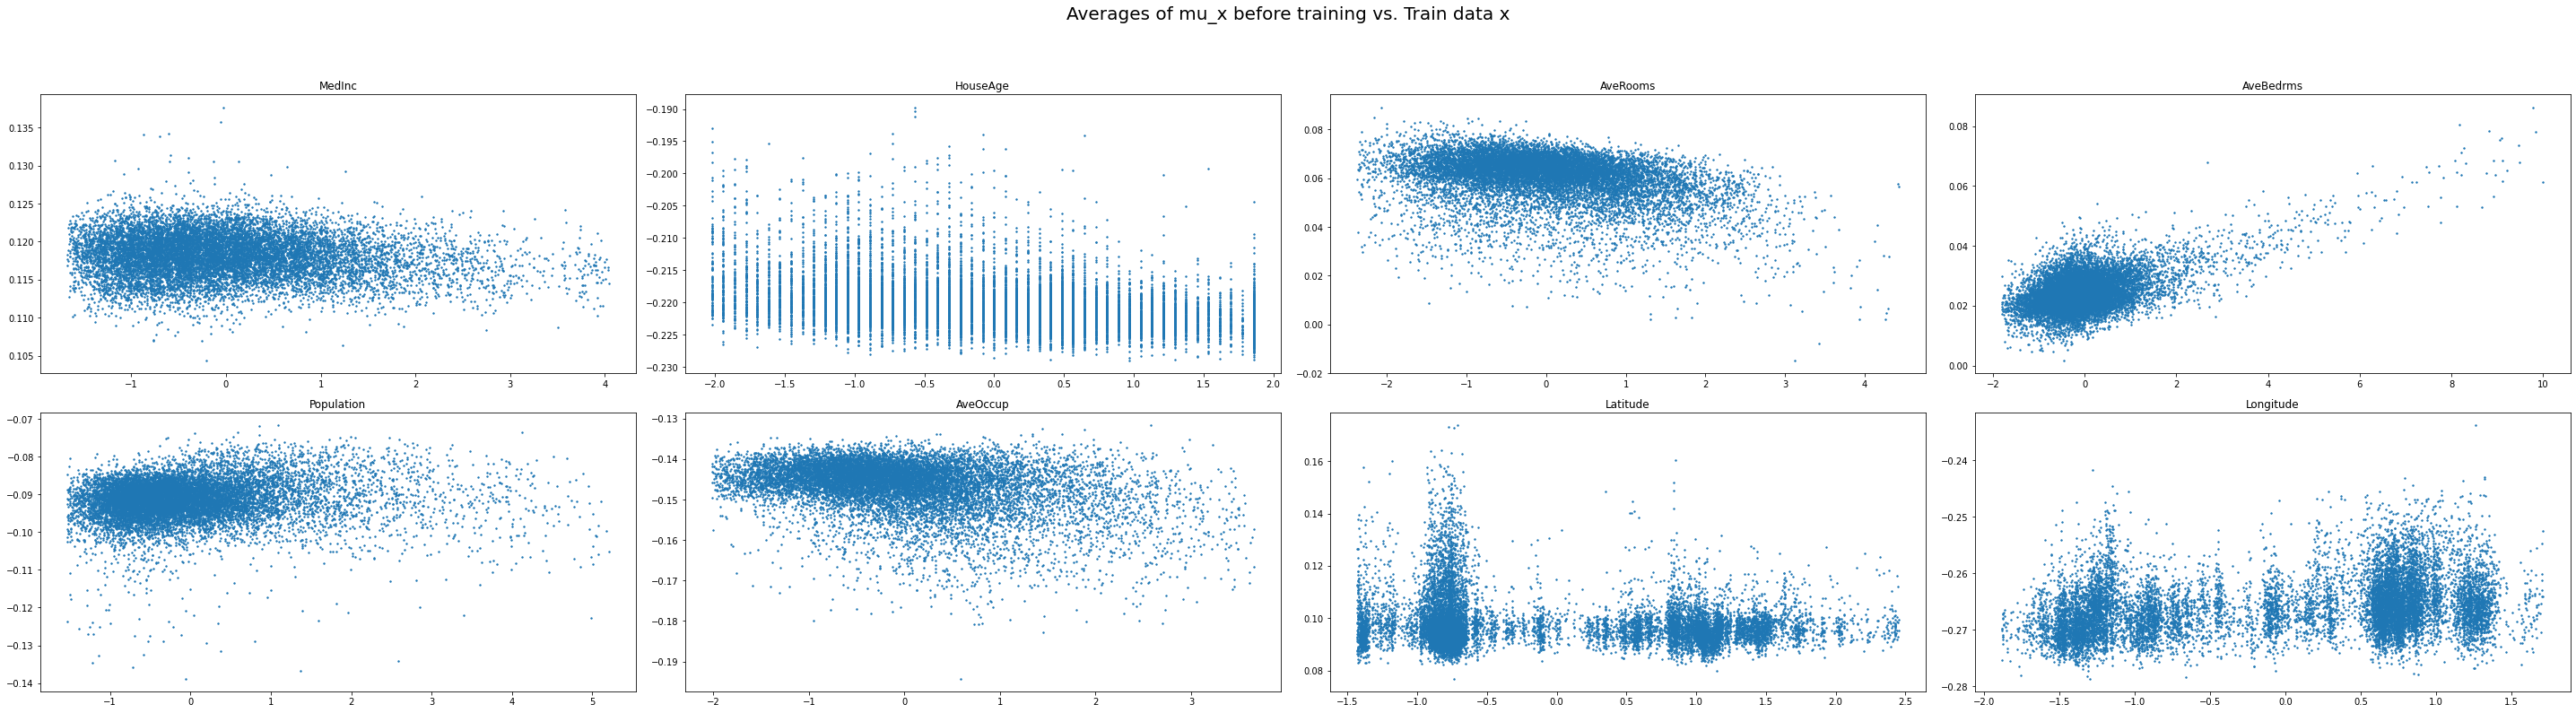

In [13]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [14]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z)
#         torch.sum(log_p_x) - torch.sum(log_p_z)
    )
    
    return torch.sum(log_q_z), torch.sum(log_p_x), torch.sum(log_p_z), loss

In [15]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [16]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [17]:
train_loss_avg = []
log_q_z_avg = []
log_p_x_avg = []
log_p_z_avg = []
test_loss_avg = []
test_log_q_z_avg = []
test_log_p_x_avg = []
test_log_p_z_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    log_q_z_avg.append(0)
    log_p_x_avg.append(0)
    log_p_z_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        log_q_z, log_p_x, log_p_z, loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        log_q_z_avg[-1] += log_q_z.item()
        log_p_x_avg[-1] += log_p_x.item()
        log_p_z_avg[-1] += log_p_z.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches
    log_q_z_avg[-1] /= num_batches
    log_p_x_avg[-1] /= num_batches
    log_p_z_avg[-1] /= num_batches

    
    with torch.no_grad():
        test_loss_avg.append(0)
        test_log_q_z_avg.append(0)
        test_log_p_x_avg.append(0)
        test_log_p_z_avg.append(0)
        num_batches = 0
        for x_test in test_iter:
            # test
            mu_z_test, std_z_test = enc(x_test)
            eps_test = torch.randn_like(std_z_test)
            z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

            mu_x_test, std_x_test = dec(z_samples_test)

            # loss 
            test_log_q_z, test_log_p_x, test_log_p_z, test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
            test_loss_avg[-1] += test_loss.item()
            test_log_q_z_avg[-1] += test_log_q_z.item()
            test_log_p_x_avg[-1] += test_log_p_x.item()
            test_log_p_z_avg[-1] += test_log_p_z.item()
            num_batches += 1
        test_loss_avg[-1] /= num_batches
        test_log_q_z_avg[-1] /= num_batches
        test_log_p_x_avg[-1] /= num_batches
        test_log_p_z_avg[-1] /= num_batches

#     if i > 50: 
#         prev_mean = sum(train_loss_avg[i-50:i])/50
#         curr_mean = sum(train_loss_avg[i-49:i+1])/50
#         if 0 <= ((prev_mean - curr_mean) / prev_mean) <= 0.00001:
#             print("CONVERGED!!!!")
#             break 
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 1000] train loss: 11.739845, test loss: 11.438891
Epoch [2 / 1000] train loss: 11.399789, test loss: 11.366956
Epoch [3 / 1000] train loss: 11.343009, test loss: 11.314702
Epoch [4 / 1000] train loss: 11.273734, test loss: 11.236305
Epoch [5 / 1000] train loss: 11.203589, test loss: 11.168862
Epoch [6 / 1000] train loss: 11.165111, test loss: 11.131382
Epoch [7 / 1000] train loss: 11.131622, test loss: 11.109953
Epoch [8 / 1000] train loss: 11.111271, test loss: 11.072608
Epoch [9 / 1000] train loss: 11.061477, test loss: 11.028839
Epoch [10 / 1000] train loss: 11.000883, test loss: 10.967208
Epoch [11 / 1000] train loss: 10.966668, test loss: 10.937684
Epoch [12 / 1000] train loss: 10.937240, test loss: 10.917884
Epoch [13 / 1000] train loss: 10.905276, test loss: 10.897329
Epoch [14 / 1000] train loss: 10.877213, test loss: 10.853787
Epoch [15 / 1000] train loss: 10.847631, test loss: 10.789997
Epoch [16 / 1000] train loss: 10.784807, test loss: 10.757821
Epoch [17 / 1000]

Epoch [137 / 1000] train loss: 8.299108, test loss: 8.350848
Epoch [138 / 1000] train loss: 8.295684, test loss: 8.321450
Epoch [139 / 1000] train loss: 8.307669, test loss: 8.314951
Epoch [140 / 1000] train loss: 8.282553, test loss: 8.320380
Epoch [141 / 1000] train loss: 8.270037, test loss: 8.314549
Epoch [142 / 1000] train loss: 8.269867, test loss: 8.330963
Epoch [143 / 1000] train loss: 8.300426, test loss: 8.327166
Epoch [144 / 1000] train loss: 8.279069, test loss: 8.317180
Epoch [145 / 1000] train loss: 8.271438, test loss: 8.300035
Epoch [146 / 1000] train loss: 8.260516, test loss: 8.309371
Epoch [147 / 1000] train loss: 8.267096, test loss: 8.307792
Epoch [148 / 1000] train loss: 8.276968, test loss: 8.339123
Epoch [149 / 1000] train loss: 8.257357, test loss: 8.366885
Epoch [150 / 1000] train loss: 8.267513, test loss: 8.321229
Epoch [151 / 1000] train loss: 8.267735, test loss: 8.311047
Epoch [152 / 1000] train loss: 8.264082, test loss: 8.322097
Epoch [153 / 1000] train

Epoch [272 / 1000] train loss: 8.118462, test loss: 8.146814
Epoch [273 / 1000] train loss: 8.108401, test loss: 8.157927
Epoch [274 / 1000] train loss: 8.088552, test loss: 8.159235
Epoch [275 / 1000] train loss: 8.110114, test loss: 8.134163
Epoch [276 / 1000] train loss: 8.102957, test loss: 8.159587
Epoch [277 / 1000] train loss: 8.096268, test loss: 8.176389
Epoch [278 / 1000] train loss: 8.108376, test loss: 8.385208
Epoch [279 / 1000] train loss: 8.151332, test loss: 8.169782
Epoch [280 / 1000] train loss: 8.108780, test loss: 8.199607
Epoch [281 / 1000] train loss: 8.129894, test loss: 8.162954
Epoch [282 / 1000] train loss: 8.104756, test loss: 8.178573
Epoch [283 / 1000] train loss: 8.100230, test loss: 8.200417
Epoch [284 / 1000] train loss: 8.093074, test loss: 8.195952
Epoch [285 / 1000] train loss: 8.096991, test loss: 8.176193
Epoch [286 / 1000] train loss: 8.091990, test loss: 8.175857
Epoch [287 / 1000] train loss: 8.089656, test loss: 8.185350
Epoch [288 / 1000] train

Epoch [407 / 1000] train loss: 7.982902, test loss: 8.059489
Epoch [408 / 1000] train loss: 8.005601, test loss: 8.020348
Epoch [409 / 1000] train loss: 7.978635, test loss: 8.030674
Epoch [410 / 1000] train loss: 7.985580, test loss: 8.046784
Epoch [411 / 1000] train loss: 7.981290, test loss: 8.023983
Epoch [412 / 1000] train loss: 7.990086, test loss: 8.230621
Epoch [413 / 1000] train loss: 8.027685, test loss: 8.036066
Epoch [414 / 1000] train loss: 7.992697, test loss: 7.999190
Epoch [415 / 1000] train loss: 7.968694, test loss: 8.063880
Epoch [416 / 1000] train loss: 7.989825, test loss: 8.035073
Epoch [417 / 1000] train loss: 7.977562, test loss: 8.033223
Epoch [418 / 1000] train loss: 7.973358, test loss: 8.029226
Epoch [419 / 1000] train loss: 8.004512, test loss: 8.077936
Epoch [420 / 1000] train loss: 7.980807, test loss: 8.029523
Epoch [421 / 1000] train loss: 7.966567, test loss: 8.029304
Epoch [422 / 1000] train loss: 7.969736, test loss: 8.004361
Epoch [423 / 1000] train

Epoch [542 / 1000] train loss: 7.943268, test loss: 8.020444
Epoch [543 / 1000] train loss: 7.941878, test loss: 7.972907
Epoch [544 / 1000] train loss: 7.932201, test loss: 7.988428
Epoch [545 / 1000] train loss: 7.942765, test loss: 7.962771
Epoch [546 / 1000] train loss: 7.928120, test loss: 7.998827
Epoch [547 / 1000] train loss: 7.923095, test loss: 7.950932
Epoch [548 / 1000] train loss: 7.936653, test loss: 7.966578
Epoch [549 / 1000] train loss: 7.915989, test loss: 7.953953
Epoch [550 / 1000] train loss: 7.900326, test loss: 7.948444
Epoch [551 / 1000] train loss: 7.913157, test loss: 7.969873
Epoch [552 / 1000] train loss: 7.914508, test loss: 7.976312
Epoch [553 / 1000] train loss: 7.921196, test loss: 7.990597
Epoch [554 / 1000] train loss: 7.911170, test loss: 7.951616
Epoch [555 / 1000] train loss: 7.925852, test loss: 7.979010
Epoch [556 / 1000] train loss: 7.906475, test loss: 7.995202
Epoch [557 / 1000] train loss: 7.925626, test loss: 7.957743
Epoch [558 / 1000] train

Epoch [677 / 1000] train loss: 7.883400, test loss: 7.962550
Epoch [678 / 1000] train loss: 7.899719, test loss: 8.006639
Epoch [679 / 1000] train loss: 7.902270, test loss: 7.973056
Epoch [680 / 1000] train loss: 7.892233, test loss: 7.950428
Epoch [681 / 1000] train loss: 7.889522, test loss: 7.921801
Epoch [682 / 1000] train loss: 7.894655, test loss: 7.907520
Epoch [683 / 1000] train loss: 7.902641, test loss: 7.984563
Epoch [684 / 1000] train loss: 7.898774, test loss: 7.930265
Epoch [685 / 1000] train loss: 7.898985, test loss: 7.955436
Epoch [686 / 1000] train loss: 7.857927, test loss: 7.944709
Epoch [687 / 1000] train loss: 7.885814, test loss: 7.928513
Epoch [688 / 1000] train loss: 7.889248, test loss: 7.953318
Epoch [689 / 1000] train loss: 7.888999, test loss: 7.958844
Epoch [690 / 1000] train loss: 7.873688, test loss: 7.948837
Epoch [691 / 1000] train loss: 7.874312, test loss: 7.984215
Epoch [692 / 1000] train loss: 7.885890, test loss: 7.941448
Epoch [693 / 1000] train

Epoch [812 / 1000] train loss: 7.862987, test loss: 7.910675
Epoch [813 / 1000] train loss: 7.859028, test loss: 7.959058
Epoch [814 / 1000] train loss: 7.863565, test loss: 7.957283
Epoch [815 / 1000] train loss: 7.988983, test loss: 8.002880
Epoch [816 / 1000] train loss: 7.919709, test loss: 7.961727
Epoch [817 / 1000] train loss: 7.893035, test loss: 7.971001
Epoch [818 / 1000] train loss: 7.895552, test loss: 7.966922
Epoch [819 / 1000] train loss: 7.872123, test loss: 7.895129
Epoch [820 / 1000] train loss: 7.870186, test loss: 7.923427
Epoch [821 / 1000] train loss: 7.873571, test loss: 7.946971
Epoch [822 / 1000] train loss: 7.867575, test loss: 7.913003
Epoch [823 / 1000] train loss: 7.898242, test loss: 7.904618
Epoch [824 / 1000] train loss: 7.872528, test loss: 7.898755
Epoch [825 / 1000] train loss: 7.848452, test loss: 7.906071
Epoch [826 / 1000] train loss: 7.860883, test loss: 7.904942
Epoch [827 / 1000] train loss: 7.859143, test loss: 7.934684
Epoch [828 / 1000] train

Epoch [947 / 1000] train loss: 7.859087, test loss: 7.921933
Epoch [948 / 1000] train loss: 7.851487, test loss: 7.867563
Epoch [949 / 1000] train loss: 7.862848, test loss: 7.913072
Epoch [950 / 1000] train loss: 7.857457, test loss: 7.901263
Epoch [951 / 1000] train loss: 7.856057, test loss: 7.884536
Epoch [952 / 1000] train loss: 7.880491, test loss: 7.904485
Epoch [953 / 1000] train loss: 7.854158, test loss: 7.891816
Epoch [954 / 1000] train loss: 7.847238, test loss: 7.920051
Epoch [955 / 1000] train loss: 7.847407, test loss: 7.888418
Epoch [956 / 1000] train loss: 7.868385, test loss: 7.907044
Epoch [957 / 1000] train loss: 7.860732, test loss: 7.889232
Epoch [958 / 1000] train loss: 7.854232, test loss: 7.943782
Epoch [959 / 1000] train loss: 7.867497, test loss: 7.879046
Epoch [960 / 1000] train loss: 7.850207, test loss: 7.882986
Epoch [961 / 1000] train loss: 7.841930, test loss: 7.907143
Epoch [962 / 1000] train loss: 7.864777, test loss: 7.907463
Epoch [963 / 1000] train

1000
1000


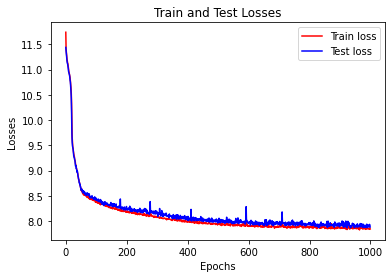

In [18]:
print(len(train_loss_avg))
print(len(test_loss_avg))
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(9, 12)
plt.title("Train and Test Losses")
plt.show()

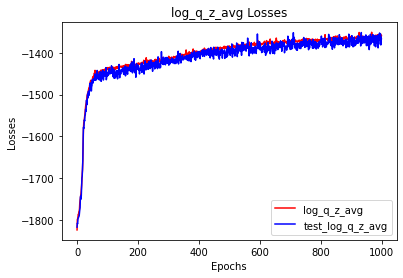

In [19]:
plt.plot(log_q_z_avg, "r")
plt.plot(test_log_q_z_avg, "b")
plt.legend(["log_q_z_avg", "test_log_q_z_avg"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.title("log_q_z_avg Losses")
plt.show()

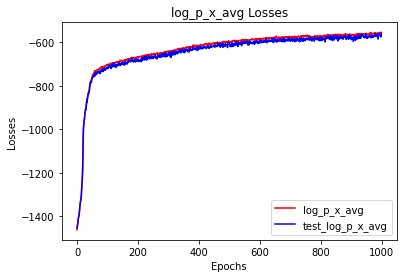

In [20]:
plt.plot(log_p_x_avg, "r")
plt.plot(test_log_p_x_avg, "b")
plt.legend(["log_p_x_avg", "test_log_p_x_avg"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.title("log_p_x_avg Losses")
plt.show()

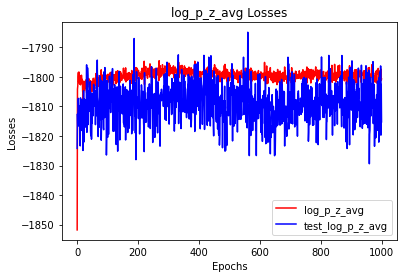

In [21]:
plt.plot(log_p_z_avg, "r")
plt.plot(test_log_p_z_avg, "b")
plt.legend(["log_p_z_avg", "test_log_p_z_avg"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.title("log_p_z_avg Losses")
plt.show()

In [22]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

In [23]:
avg_mu_x_trained

array([[ 0.37964413, -0.15524888,  0.18708739, ...,  0.24150646,
        -0.8695362 ,  0.8765314 ],
       [-0.4584914 , -0.5687077 ,  0.14269173, ..., -0.21915825,
         1.3665252 , -0.8689253 ],
       [ 0.17630386,  1.5700885 , -0.17257825, ..., -0.76381904,
         1.03816   , -1.4418143 ],
       ...,
       [-0.47219956,  0.4790496 , -0.7893061 , ...,  0.23184259,
        -0.80274177,  0.7438085 ],
       [-0.8975395 , -0.25227538, -0.7059033 , ...,  0.4206076 ,
        -0.82465136,  1.0129232 ],
       [ 1.2437006 , -0.7123136 ,  1.0003164 , ...,  0.15076505,
         1.069982  , -1.2269342 ]], dtype=float32)

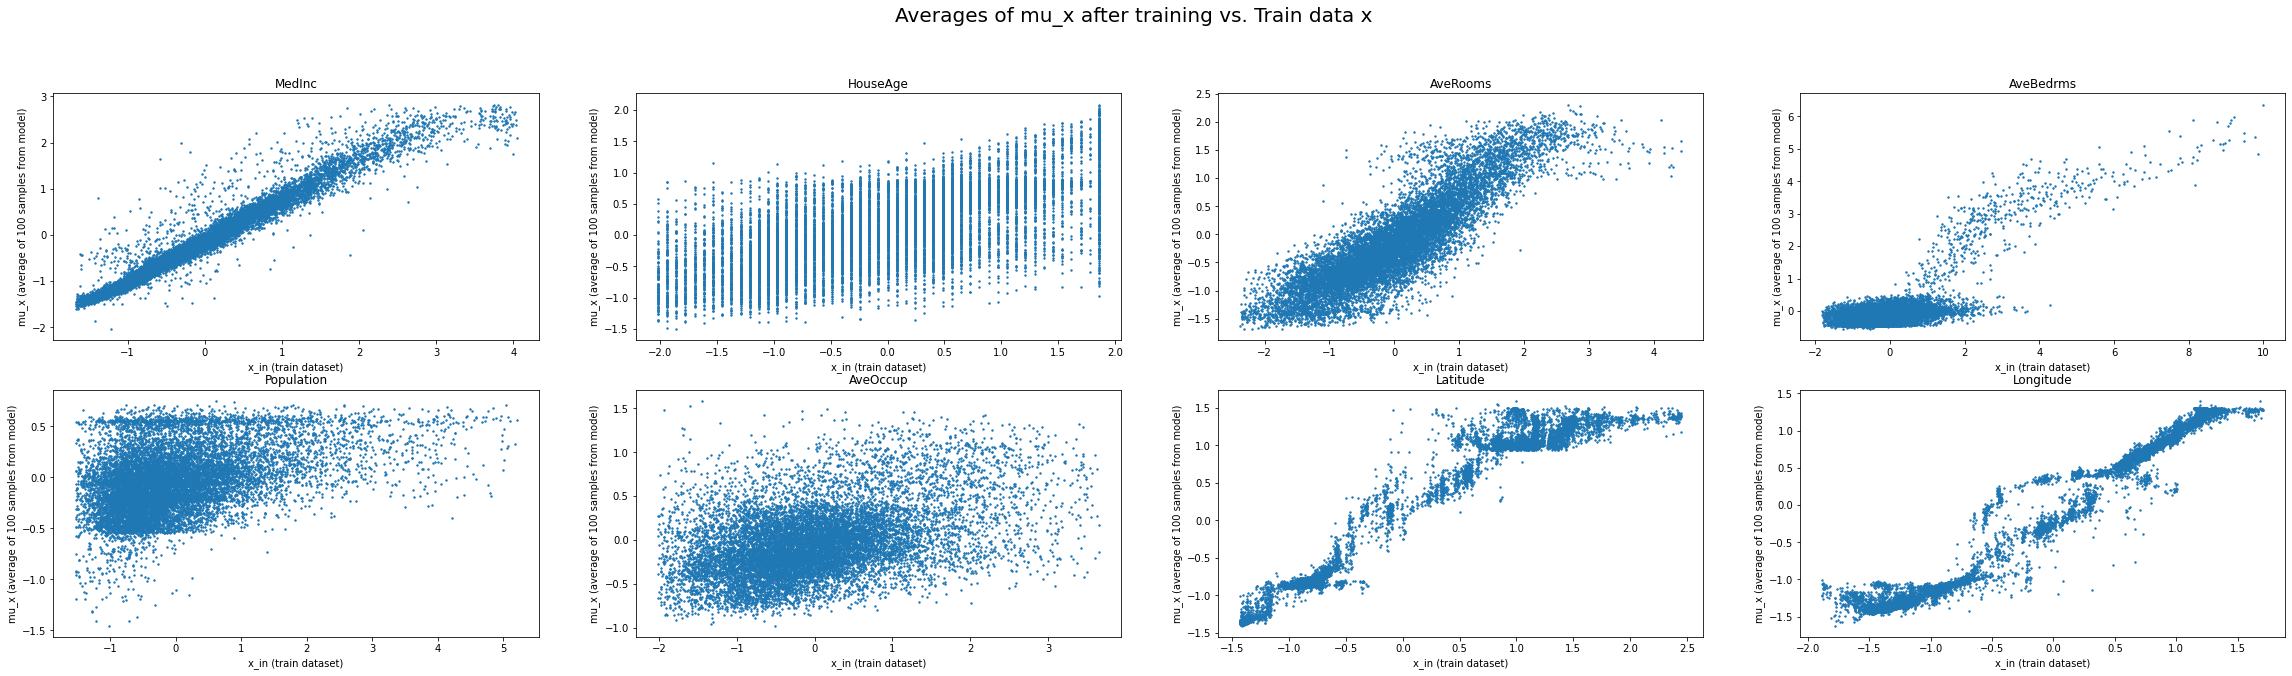

In [24]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [25]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [26]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([1000, 8])


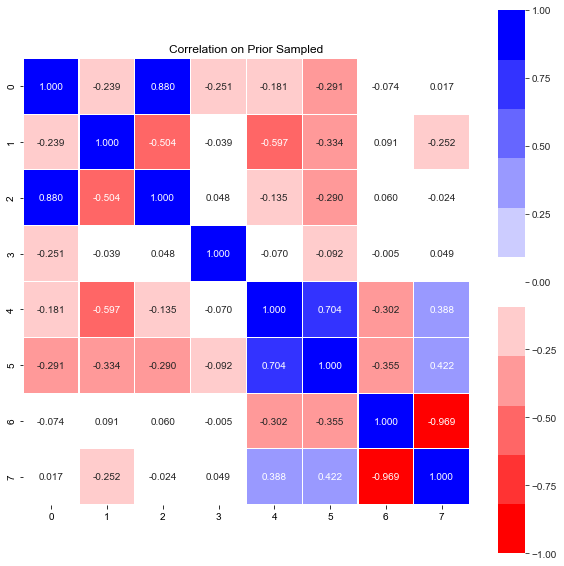

In [27]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

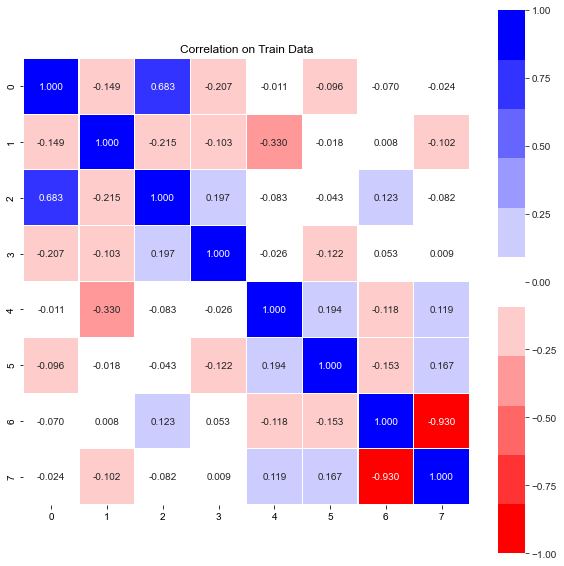

In [28]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

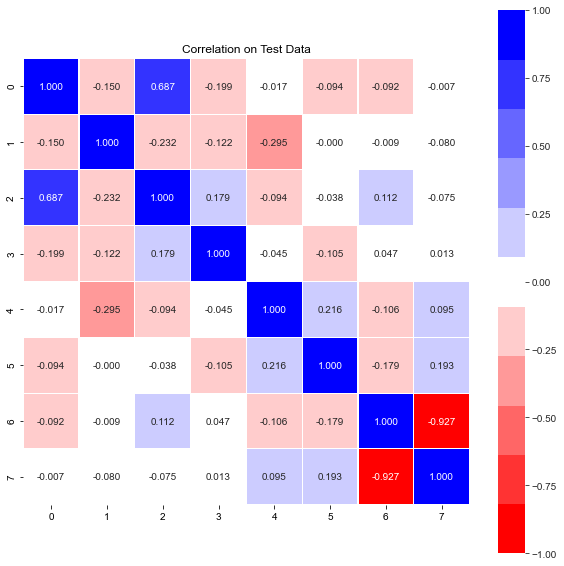

In [29]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [30]:
# z = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
# mu_x, std_x = dec(z)

# # X_test = X_test.numpy()
# mu_x = mu_x.detach().numpy()

# figs, axs = plt.subplots(X_test.shape[1], 2, figsize=(20, 100))

# for i in range(X_test.shape[1]):
# #     x_test_mean = x_test[:,i].mean()
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
#     axs[i, 1].hist(mu_x[:,i])
#     axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

# plt.show()